In [1]:
!pip install fairlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 18.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3


In [8]:
import pandas as pd
import numpy as np

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# fairness metrics
from fairlearn.metrics import MetricFrame, selection_rate

# plotting
import matplotlib.pyplot as plt

In [9]:
# Load Titanic dataset
df = sns.load_dataset('titanic')

# Keep only relevant columns
df = df[['survived','sex','age','pclass','fare','alone']]

# Drop missing values (for simplicity)
df.dropna(inplace=True)

# Inspect first 5 rows
df.head()


,survived,sex,age,pclass,fare,alone
0,0,male,22.0,3,7.2500,False
1,1,female,38.0,1,71.2833,False
2,1,female,26.0,3,7.9250,True
3,1,female,35.0,1,53.1000,False
4,0,male,35.0,3,8.0500,True


In [10]:
# Target variable
y = df['survived']

# Input features
X = df.drop(columns=['survived'])

# Sensitive feature for fairness
sensitive = df['sex']


In [11]:
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = train_test_split(
    X, y, sensitive, test_size=0.3, stratify=y, random_state=42
)


In [12]:
# Identify categorical features
categorical_features = ['sex', 'alone']

# ColumnTransformer applies transformations to only certain columns
preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), categorical_features)
], remainder='passthrough')  # numeric columns like age, fare, pclass are passed as-is

# Pipeline: preprocessing + model
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=500))
])


In [13]:
# Fit model
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)


In [14]:
# MetricFrame computes metrics by sensitive groups
metric_frame = MetricFrame(
    metrics={
        "accuracy": accuracy_score,
        "selection_rate": selection_rate
    },
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sensitive_test
)

# Show metrics by group
metric_frame.by_group


,accuracy,selection_rate
sex,,
female,0.731707,0.926829
male,0.819549,0.097744


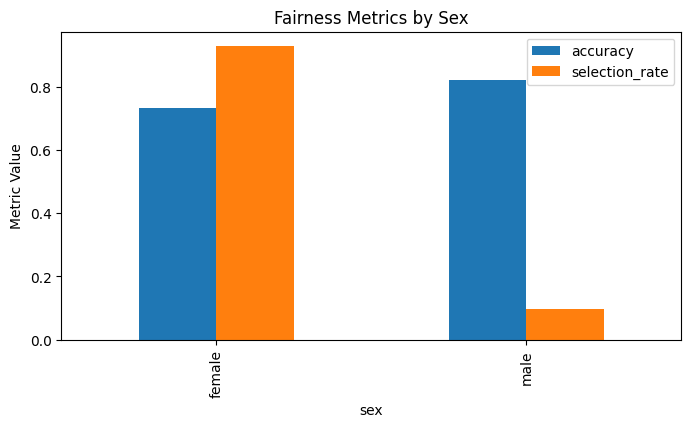

In [15]:
metric_frame.by_group.plot(kind='bar', figsize=(8,4), title='Fairness Metrics by Sex')
plt.ylabel('Metric Value')
plt.show()


In [16]:
print("Overall Accuracy:", accuracy_score(y_test, y_pred))
print("\nAccuracy by sex:\n", metric_frame.by_group['accuracy'])
print("\nSelection Rate by sex:\n", metric_frame.by_group['selection_rate'])


Overall Accuracy: 0.786046511627907

Accuracy by sex:
 sex
female    0.731707
male      0.819549
Name: accuracy, dtype: float64

Selection Rate by sex:
 sex
female    0.926829
male      0.097744
Name: selection_rate, dtype: float64
